## Precision and Recall

In [1]:
# !pip install -q scikit-learn==1.0.1
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics, preprocessing
import itertools
from typing import List, Dict, Optional, Union

In [2]:
def confusion_matrix_(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """Calculates the confusion matrix.
    We assume that the inputs are binarized already.
    This can be used in both binary and multiclass classification
    provided that we label binarized the multiclass labels.

    Args:
        y_true (np.ndarray): the correct labels, shape (n_samples, )
        y_pred (np.ndarray): the predicted labels, shape (n_samples, )

    Returns:
        cm (np.ndarray): the confusion matrix, shape (n_classes, n_classes)
                         with [[tp, fp], [fn, tn]]
    """
    tp, fp, fn, tn = 0, 0, 0, 0

    for y_t, y_p in zip(y_true, y_pred):
        # if actual and predicted both are positive class
        if y_t == y_p == 1:
            tp += 1
        # if actual and predicted both are negative class
        elif y_t == y_p == 0:
            tn += 1
        # if actual is negative and predicted is positive
        elif y_t == 0 and y_p == 1:
            fp += 1
        # if actual is positive and predicted is negative
        elif y_t == 1 and y_p == 0:
            fn += 1

    cm = np.asarray([[tp, fp], [fn, tn]])
    return cm

def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    title: str,
    labels: List[str],
    tick_labels: List[str],
) -> None:
    """Plots a Binary Confusion Matrix.

    Args:
        y_true (np.ndarray): the actual labels.
        y_pred (np.ndarray): the predicted labels.
        title (str): the title of the plot.
        tick_labels (List[str]): The labels for the ticks.
    """

    # Unravel into tn, fp, fn and tp
    tn, fp, fn, tp = metrics.confusion_matrix(
        y_true, y_pred, labels=labels
    ).ravel()

    # reshape into tp, fp, fn, tn - this is personal preference
    reshaped_cm = np.asarray([[tp, fp], [fn, tn]])

    # flatten this 2d array
    cm_flattened = reshaped_cm.flatten()

    labels = [
        "True Positive",
        "False Positive",
        "False Negative",
        "True Negative",
    ]
    annot = (
        np.asarray(
            [
                f"{label}\n{cm_count}"
                for label, cm_count in zip(labels, cm_flattened)
            ]
        )
    ).reshape(2, 2)

    ax = plt.subplot()
    heatmap = sns.heatmap(
        reshaped_cm,
        annot=annot,
        fmt="",
        cmap="Greens",
        ax=ax,
        xticklabels=tick_labels,
        yticklabels=tick_labels,
    )
    ax.set_title(title)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    plt.show()

## **Precision**

### Definition

!!! success "Definition"
    Precision measures how many of the samples predicted as positive are actually positive. Mathematically, it is expressed as:

    $$\text{Precision} = \dfrac{\text{TP}}{\text{TP} + \text{FP}}=P(Y=1 | \hat{Y} = 1)$$

---

!!! info "Probablistic Interpretation"
    Notice that the above definition has a probabilitic interpretation $P(Y = 1 | \hat{Y} = 1)$, where $Y$ and $\hat{Y}$ refers to the actual label and predicted labels respectively. We interpreted precision and recall not as ratios but as [estimations of probabilities](https://en.wikipedia.org/wiki/Precision_and_recall).
    Precision is then the estimated probability that a random point selected from the samples are positive. This might be a tough pill to swallow as someone who was never good in statistics but it is just conditional probability. If you try to think a bit further, you can form an intuition as follows:
    > If your classifier $h$ is trained and the last layer is say, sigmoid, which in binary classification, calibrates the logits and turn them into probabilities. Then it can be interpretated that given a randomly chosen point $x \in X_{train}$, what is the probability of this point $x$ to be positive given that it is predicted as positive by the classifer?

---

Informally, precision answers the question **what proportion of positive predictions was actually correct**? In other words, out of all the positive predictions made by the model, how many of those positive predictions were actually positive when compared to the ground truth?

---

When I learned this back then, it is not immediately obvious what the denominator is doing. Dissecting the formula helps. The loose dynamics is that TP and FP are inversely related, and assuming a fixed threshold, the denominator is fixed as follows:

$$\text{Predicted Number of Positives} = \text{TP} + \text{FP}$$    

Thus, minimizing FP is equivalent to maximizing TP, doing so will lead to an increase in precision.

---

!!! note
    Just like the confusion matrix, we yield different precision score should we treat benign as the positive class.

---

!!! example
    Consider a email company that developed a email spam detector for their uses. There are two outcomes/classes:
    ```python
    positive class = spam
    negative class = not spam
    ```
    From the company's perspective, they will be optimizing precision over recall because they want the spam detector to have minimal False Positives because predicting an not spam (which could be an important email) email as spam is much more costly than predicting a spam email as not spam. Imagine your important emails being put into spam folder by the spam detector?!

### When to use Precision?

- When your company needs you to ***restrict the number of False Positives***. Prime examples are email spam prediction.

- There is a trade-off between precision and recall, and restricting the number of FP ***may*** give rise to the increase in FN. So ultimately, bear in mind that it is not simply a matter of ***restricting the number of False Positives*** but a matter of ***use cases in your business setting, on whether achieving lesser FP is more important than achieving a lesser FN***.

### When NOT to use Precision?

!!! danger
    - If you have a precision score of 1, then this means that $TP = TP + FP = 1 \implies FP = 0$. This means it can be achieved if your predictions have 0 False Positives, but this does not tell us **anything** about the False Negatives.
    - When you prioritize recall/sensitivity more than precision for your business needs.
    - You should never ever use `precision` as a single metric.

### Implementation of Precision

In [3]:
y_true = np.array([1, 1, 0, 1, 0, 0, 1, 0, 0, 1])
y_pred = np.array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0])


tp, fp, fn, tn = confusion_matrix_(y_true, y_pred).ravel()
reighns_precision = tp / (tp + fp)

print(f"our precision: {reighns_precision}")

sklearn_precision = metrics.precision_score(y_true, y_pred, average="binary")

print(f"sklearn precision: {sklearn_precision}")

our precision: 0.75
sklearn precision: 0.75


## Recall/Sensitivity/True Positive Rate

### Definition

!!! success "Definition"
    Recall measures the following: out of all the actual positives (say, the real cancer patients), how many of them were identified correctly by the classifier? Mathematically, it is expressed as:
    
    $$\text{Recall}= \dfrac{\text{TP}}{\text{TP} + \text{FN}}= P(\hat{Y}=1 | Y = 1)=1-FNR$$

---

!!! info "Probabilistic Interpretation"
    Similarly, we can interpret recall probabilistically like how we did to precision. Recall is the conditional probability of the sample being predicted as positive given that the sample is positive.

---

!!! note
    From the formula, we see the denominator to be defined as TP + FN, which is unsurprising as this gives you the actual number of positives. The dynamics is also similar to the one in precision.

!!! example
    For cancer data modeling, anything that doesn't account for false-negatives is like committing a crime indirectly (a strong statement, but lives are at stake here!). Recall is a better measure than precision in this aspect assuming that the positive class is malignant.
    ```python
    positive class = malignant
    negative class = benign
    ```
    A healthcare company came up with a cancer test kit. Instead of reporting its accuracy, we should examine the recall first as the test kit should have minimum False Negatives because predicting a patient with cancer as benign yields a much higher cost than predicting a healthy patient to have cancer. You really do not want to miss any sick patients, you will see later on how we can tune the decision threshold of a classifier to achieve a higher recall at the expense of lowering precision.  

### When to use Recall?

- When your company needs you to ***restrict the number of False Negatives***.

### When to NOT use Recall?

!!! danger
    - If you have a recall score of 1, then this means that $TP = TP + FN = 1 \implies FN = 0$; there are 0 False Negatives, but this does not tell us **anything** about the False Positives.
    - When you prioritize precision more than recall for your business needs.
    - You almost never ever use `recall` as a single metric.

### Implementation of Recall

In [4]:
y_true = np.array([1, 1, 0, 1, 0, 0, 1, 0, 0, 1])
y_pred = np.array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0])


tp, fp, fn, tn = confusion_matrix_(y_true, y_pred).ravel()
reighns_recall = tp / (tp + fn)

print(f"our recall: {reighns_recall}")

sklearn_recall = metrics.recall_score(y_true, y_pred, average="binary")

print(f"sklearn recall: {sklearn_recall}")

our recall: 0.6
sklearn recall: 0.6


## The Precision-Recall Tradeoff

Does this term reminisce with the Bias-Variance Tradeoff? More specifically, when we talk about precision and recall in the sections above, we are fixated at one **decision threshold** of our classifier. One should note that both metrics are parametrized by $t$, the decision threshold. We can tune our threshold to achieve a better precision or recall, but usually not both, hence the tradeoff. 

---

We can read more from [Google's Machine Learning Crash Course on Precison and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall).

## Specificity/True Negative Rate

!!! success "Definition"
    $$TNR = \dfrac{TN}{TN + FP} = P(\hat{Y} = 0| Y=0) = 1 - FPR$$

## False Positive Rate

!!! success "Definition"
    Out of all the real negative classes (negative ground truth), how many were predicted wrongly (predicted as positive from the model).
   
    $$FPR = \dfrac{FP}{FP + TN}=1-TNR$$

## False Negative Rate

!!! success "Definition"
    $$TNR = \dfrac{FN}{FN + TP} = 1 - TPR$$

## F1-Score

### Intuition

Motivated by the examples above, where using single precision or recall do not tell us much about the whole story. We thus turn to a combination of the above metrics. Penalizes extreme values of precision and recall more than arithmetic mean[^1].

[^1]: https://stackoverflow.com/questions/26355942/why-is-the-f-measure-a-harmonic-mean-and-not-an-arithmetic-mean-of-the-precision/26360501#26360501

### Definition

!!! success "Definition"
    The F1 score is the <b>harmonic mean</b> between Precision and Recall, bounded between 0 and 1. 

    $$F1 = \dfrac{2(\text{Precision} \times \text{Recall})}{\text{Precision} + \text{Recall}}$$

!!! example
    TO CITE: For example, imagine that the blood protein levels in diseased people and healthy people are normally distributed with means of 2 g/dL and 1 g/dL respectively. A medical test might measure the level of a certain protein in a blood sample and classify any number above a certain threshold as indicating disease. The experimenter can adjust the threshold (black vertical line in the figure), which will in turn change the false positive rate. Increasing the threshold would result in fewer false positives (and more false negatives), corresponding to a leftward movement on the curve. The actual shape of the curve is determined by how much overlap the two distributions have.

## Multiclass Classification

We can extend the binary classification metrics to a multiclass classification setting. Initially, it is not entirely clear how we should handle precision, recall and f1-score because metrics like False Negatives are not well defined - we simply do not know who is the "positive" and "negative" class here. It turns out that this is not a problem if we use the One-vs-Rest scheme.

We introduce two ways to do so, which is either using micro-averaging, or macro-averaging. Before we go deeper, we first need to understand the notion of One-vs-Rest.

Consider a multiclass problem with 3 labels:  
```python
# Our dataset is as follows
label_dict = {"benign": 0, "borderline": 1, "malignant": 2}
classes = [0, 1, 2]
y_true = np.array(
    ["benign", "borderline", "malignant", "benign", "borderline", "malignant"]
)
y_pred = np.array(
    ["benign", "malignant", "borderline", "benign", "benign", "borderline"]
)

# Turn them into numbers in the label_dict
y_true = np.array([label_dict[label] for label in y_true])
y_pred = np.array([label_dict[label] for label in y_pred])
```
We can calculate the metrics (precision etc) for each label indepedently. What we mean here is that we treat an n-class problem as n-binary classification problem, such as the following:

!!! example "Benign as Positive Class"
    If we take benign as positive class, which is represented as 1, and both borderline and malignant as the negative class 0, then logically (even without the fancy term label binarize), we can just simply replace as follows:
    ```python
    y_true = [0,1,2,0,1,2] -> y_true = [1,0,0,1,0,0]
    y_pred = [0,2,1,0,0,1] -> y_pred = [1,0,0,1,1,0]
    ```
    where we just replace all 0 (initially benign) to 1, and all 1 and 2 (initially borderline and malignant) to 0 (may be confusing at first).

!!! example "Borderline as Positive Class"
    If we take borderline as positive class, which is represented as 1, and both benign and malignant as the negative class 0, then logically (even without the fancy term label binarize), we can just simply replace as follows:
    ```python
    y_true = [0,1,2,0,1,2] -> y_true = [0,1,0,0,1,0]
    y_pred = [0,2,1,0,0,1] -> y_pred = [0,0,1,0,0,1]
    ```
    where we just replace all 1 (initially borderline) to 1, and all 0 and 2 (initially benign and malignant) to 0.

!!! example "Malignant as Positive Class"
    If we take malignant as positive class, which is represented as 2, and both benign and borderline as the negative class 0, then logically (even without the fancy term label binarize), we can just simply replace as follows:
    ```python
    y_true = [0,1,2,0,1,2] -> y_true = [0,0,1,0,0,1]
    y_pred = [0,2,1,0,0,1] -> y_pred = [0,1,0,0,0,0]
    ```
    where we just replace all 2 (initially malignant) to 1, and all 0 and 1 (initially benign and borderline) to 0.

---

In this case, we have 3 different confusion matrices, one for each class (diagram). In the example above, we did not mention a crucial technique, which is called label binarizer[^1]. We will introduce it in code below.

[^1]: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

In [5]:
# Our dataset is as follows
label_dict = {"benign": 0, "borderline": 1, "malignant": 2}
classes = [0, 1, 2]
y_true = np.array(
    ["benign", "borderline", "malignant", "benign", "borderline", "malignant"]
)
y_pred = np.array(
    ["benign", "malignant", "borderline", "benign", "benign", "borderline"]
)

# Turn them into numbers in the label_dict
y_true = np.array([label_dict[label] for label in y_true])
y_pred = np.array([label_dict[label] for label in y_pred])

### Label Binarize

What we have just done in the previous example is that we binarized both `y_true` and `y_pred`. The process of treating each class $C_i$ as an independent class and then applying the "replacement" technique is called label binarizing. 

<figure>
    <img src='https://storage.googleapis.com/reighns/reighns_ml_projects/docs/metrics/classification_metrics/label_binarize.png'/>
    <figcaption>Label Binarizing, by Hongnan G.</figcaption>
</figure>

???+ note "Steps to label binarize"
    1. For each label (0, 1 and 2 here), we call `np.where` such that whenever the y array has this label, we replace it with 1 (positive class), and 0 otherwise (negative class).
    ```python
    binarized_cols = []
    for label in classes:
        binarize_col = np.where(y_true == label, 1, 0)
        binarized_cols.append(binarize_col)
    ```
    2. Conventially, we stack them column wise as follows: 
    ```python
    binarized_cols = np.vstack(binarized_cols)
    binarized_cols = binarized_cols.T
    ```
Let us look at the binarized array for `y_true`, notice that the first column `[1,0,0,1,0,0]` corresponds exactly to the example above when we treat benign as positive class (we can verify the same for the rest).

```python
array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
```
We note that it is commom practice to label binarize the y values first before passing in for metric calculation.




In [6]:
binarized_cols = []
for label in classes:
    binarize_col = np.where(y_true == label, 1, 0)
    binarized_cols.append(binarize_col)

np.vstack(binarized_cols).T

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

### Macro-Averaging



Back to where we ended off, we have 3 confusion matrices, we filled up each cell manually by inspection over which is considered TP, FP, FN or TN. Well, the good news is, with label binarizing done, we can just use our good ol' `confusion_matrix_` function done earlier to calculate them for us!



In [7]:
def multiclass_label_binarize(
    y: np.ndarray, class_labels: List[int], pos_label=1, neg_label=0
):
    """Binarize labels in one-vs-all fashion.
    # TODO: to replace with the above vstack method.

    Args:
        y (np.ndarray) Sequence of integer labels to encode
        class_labels (array-like) Labels for each class
        pos_label (int) Value for positive labels
        neg_label (int) Value for negative labels
    Returns:
        np.ndarray of shape (n_samples, n_classes) Encoded dataset
    """
    if isinstance(y, list):
        y = np.asarray(y)

    columns = [
        np.where(y == label, pos_label, neg_label) for label in class_labels
    ]

    return np.column_stack(columns)

In [8]:
# Binarize the labels
y_true_binarized = multiclass_label_binarize(y_true, classes)
y_pred_binarized = multiclass_label_binarize(y_pred, classes)

In [9]:
tp_c1, fp_c1, fn_c1, tn_c1 = \
    confusion_matrix_(
    y_true_binarized[:, 0], y_pred_binarized[:, 0]
    ).ravel()

tp_c2, fp_c2, fn_c2, tn_c2 = \
    confusion_matrix_(
    y_true_binarized[:, 1], y_pred_binarized[:, 1]
    ).ravel()

tp_c3, fp_c3, fn_c3, tn_c3 = \
    confusion_matrix_(
    y_true_binarized[:, 2], y_pred_binarized[:, 2]
    ).ravel()

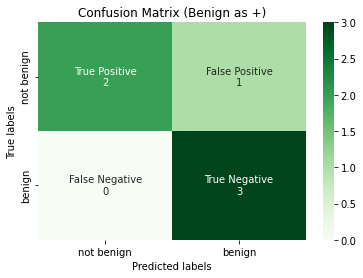

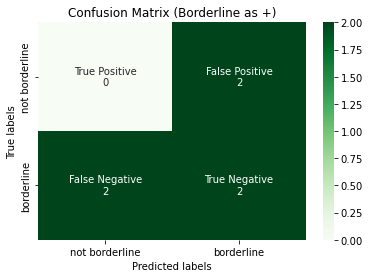

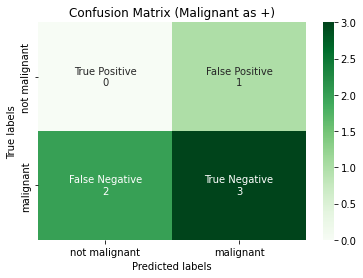

In [10]:
plot_confusion_matrix(
    y_true_binarized[:, 0],
    y_pred_binarized[:, 0],
    title="Confusion Matrix (Benign as +)",
    labels=[0, 1],
    tick_labels=["not benign", "benign"],
)
plot_confusion_matrix(
    y_true_binarized[:, 1],
    y_pred_binarized[:, 1],
    title="Confusion Matrix (Borderline as +)",
    labels=[0, 1],
    tick_labels=["not borderline", "borderline"],
)
plot_confusion_matrix(
    y_true_binarized[:, 2],
    y_pred_binarized[:, 2],
    title="Confusion Matrix (Malignant as +)",
    labels=[0, 1],
    tick_labels=["not malignant", "malignant"],
)

Then Macro-Average is calculated for each confusion matrix, and then averaged over the total number of classes.

$$\text{Macro-Average Precision} = \frac{1}{\text{num_class}}\sum_{i=1}^{\text{num_class}}P_{i}$$

where $P_i$ is the precision score for each individual confusion matrix for each class. This can be extended for recall and f1 etc.

In [11]:
# Macro-Average
precision_c1 = tp_c1 / (
    tp_c1 + fp_c1
)  # precision for confusion matrix 1 where benign is +
precision_c2 = tp_c2 / (tp_c2 + fp_c2)
precision_c3 = tp_c3 / (tp_c3 + fp_c3)

print(precision_c1, precision_c2, precision_c3)
print(
    f"Macro-Averaged Precision: {np.sum([precision_c1, precision_c2, precision_c3]) / len(classes)}"
)

0.6666666666666666 0.0 0.0
Macro-Averaged Precision: 0.2222222222222222


### Micro-Averaging

Similar to Micro-Averaging, we still have 3 confusion matrices, but we first aggregate all the 3 confusion matrices into one single confusion matrices.

$$TP_{\text{agg}}=\frac{1}{\text{num_class}}\sum_{i=1}^{\text{num_class}}TP_{i}$$

$$FP_{\text{agg}}=\frac{1}{\text{num_class}}\sum_{i=1}^{\text{num_class}}FP_{i}$$

$$FN_{\text{agg}}=\frac{1}{\text{num_class}}\sum_{i=1}^{\text{num_class}}FN_{i}$$

$$TN_{\text{agg}}=\frac{1}{\text{num_class}}\sum_{i=1}^{\text{num_class}}TN_{i}$$

And then once we get the aggregated metrics, we can apply the normal calculation to it.

$$\text{Precision} = \frac{TP_{\text{agg}}}{TP_{\text{agg}} + FP_{\text{agg}}}$$

In [12]:
tp_c1, fp_c1, fn_c1, tn_c1 = \
    confusion_matrix_(
    y_true_binarized[:, 0], y_pred_binarized[:, 0]
    ).ravel()

tp_c2, fp_c2, fn_c2, tn_c2 = \
    confusion_matrix_(
    y_true_binarized[:, 1], y_pred_binarized[:, 1]
    ).ravel()

tp_c3, fp_c3, fn_c3, tn_c3 = \
    confusion_matrix_(
    y_true_binarized[:, 2], y_pred_binarized[:, 2]
    ).ravel()

In [13]:
# Aggregation
tp_agg = (tp_c1 + tp_c2 + tp_c3) / 3
fp_agg = (fp_c1 + fp_c2 + fp_c3) / 3
fn_agg = (fn_c1 + fn_c2 + fn_c3) / 3
tn_agg = (tn_c1 + tn_c2 + tn_c3) / 3

# Calculate precision using Micro-Averaging
print(f"Micro-Averaged Precision: {tp_agg / (tp_agg + fp_agg)}")

Micro-Averaged Precision: 0.3333333333333333


### Micro vs Macro

The following content is taken from DataScienceExchange[^1].

Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes). 

To illustrate why, take for example precision $Pr=\frac{TP}{(TP+FP)}$. Let's imagine you have a *One-vs-All* (there is only one correct class output per example) multi-class classification system with four classes and the following numbers when tested:

* Class A: 1 TP and 1 FP
* Class B: 10 TP and 90 FP
* Class C: 1 TP and 1 FP
* Class D: 1 TP and 1 FP

You can see easily that $Pr_A = Pr_C = Pr_D = 0.5$, whereas $Pr_B=0.1$.

* A macro-average will then compute: $Pr=\frac{0.5+0.1+0.5+0.5}{4}=0.4$
* A micro-average will compute: $Pr=\frac{1+10+1+1}{2+100+2+2}=0.123$

These are quite different values for precision. Intuitively, in the macro-average the "good" precision (0.5) of classes A, C and D is contributing to maintain a "decent" overall precision (0.4). While this is technically true (across classes, the average precision is 0.4), it is a bit misleading, since a large number of examples are not properly classified. These examples predominantly correspond to class B, so they only contribute 1/4 towards the average in spite of constituting 94.3% of your test data. The micro-average will adequately capture this class imbalance, and bring the overall precision average down to 0.123 (more in line with the precision of the dominating class B (0.1)).

For computational reasons, it may sometimes be more convenient to compute class averages and then macro-average them. If class imbalance is known to be an issue, there are several ways around it. One is to report not only the macro-average, but also its standard deviation (for 3 or more classes). Another is to compute a weighted macro-average, in which each class contribution to the average is weighted by the relative number of examples available for it. In the above scenario, we obtain:

$Pr_{macro-mean}={0.25·0.5+0.25·0.1+0.25·0.5+0.25·0.5}=0.4$
$Pr_{macro-stdev}=0.173$

$Pr_{macro-weighted}={0.0189·0.5+0.943·0.1+0.0189·0.5+0.0189·0.5}={0.009+0.094+0.009+0.009}=0.123$

The large standard deviation (0.173) already tells us that the 0.4 average does not stem from a uniform precision among classes, but it might be just easier to compute the weighted macro-average, which in essence is another way of computing the micro-average.

[1^]: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

### Building our own Classification Report

Just like scikit-learn's [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report), we can build our own and test if it correct.

The code is made easy to follow such that you can detail each step in details if you do not understand how micro or macro is calculated.

In [14]:
def classification_report_(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    class_labels: List[int],
    display_labels: Union[Optional[List[str]], Optional[List[int]]] = None,
) -> Union[List[float], Dict[str, float]]:
    """Classification report that reports precision, recall and f1-score.

    Args:
        y_true (np.ndarray): Ground truth (correct) target values.
        y_pred (np.ndarray): Predicted target values.
        class_labels (List[int]): List of class labels.
        display_labels: List of display labels.
                        (if None, class_labels is used).

    Returns:
        confusion_matrices (List[np.ndarray]): List of confusion matrices.
        tp_fp_fn_tn (Dict[str, float]): List of true positive, false positive,
                                        true negative and false negative
                                        values.
        metrics Dict[str, float]: List of precision, recall and f1-score
                                    values.
    """
    if display_labels is None:
        # assign display labels to default labels if none is passed in.
        display_labels = class_labels  
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    y_true_binarized = multiclass_label_binarize(
        y_true, class_labels, pos_label=1, neg_label=0
    )
    y_pred_binarized = multiclass_label_binarize(
        y_pred, class_labels, pos_label=1, neg_label=0
    )

    confusion_matrices: Dict[str, List[int]] = {}
    tp_fp_fn_tn: Dict[str, List[float]] = {}
    metrics: Dict[str, List[float]] = {}

    for index, label in enumerate(class_labels):
        assert (
            index == label
        ), "Index should coincide with label,\
            if not, please check how your classes are labelled."
        cm = confusion_matrix_(
            y_true_binarized[:, index], y_pred_binarized[:, index]
        )
        confusion_matrices[display_labels[index]] = cm
        tp, fp, fn, tn = cm.ravel()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (
            2 * (precision * recall) / (precision + recall)
            if (precision + recall) != 0
            else 0
        )
        tp_fp_fn_tn[display_labels[index]] = {
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }

    def calculate_micro_avg(confusion_matrices) -> Dict[str, float]:
        """Calculate micro average for precision, recall and f1-score.

        Args:
            confusion_matrices ([type]): Pass in from local scope.

        Returns:
            Dict[str, float]: Dictionary of micro average values.
        """
        tp_agg, fp_agg, fn_agg, tn_agg = 0, 0, 0, 0
        micro_metrics: Dict[str, List[float]] = {}
        total_count = 0
        for cm in confusion_matrices.values():
            tp, fp, fn, tn = cm.ravel()
            tp_agg += tp
            fp_agg += fp
            fn_agg += fn
            tn_agg += tn
            total_count += 1

        assert total_count == len(
            class_labels
        ), "Denominator total_count should equal number of class labels."

        tp_agg, fp_agg, fn_agg, tn_agg = (
            np.asarray([tp_agg, fp_agg, fn_agg, tn_agg]) / total_count
        )  # aggregation is performed here using numpy broadcasting

        micro_precision = tp_agg / (tp_agg + fp_agg)
        micro_recall = tp_agg / (tp_agg + fn_agg)
        micro_f1 = (
            2
            * (micro_precision * micro_recall)
            / (micro_precision + micro_recall)
            if (micro_precision + micro_recall) != 0
            else 0
        )
        return {
            "micro_precision": micro_precision,
            "micro_recall": micro_recall,
            "micro_f1": micro_f1,
        }

    metrics["micro_scores"] = calculate_micro_avg(confusion_matrices)

    def calculate_macro_avg(confusion_matrices) -> Dict[str, float]:
        """Calculate macro average for precision, recall and f1-score.

        Args:
            confusion_matrices ([type]): Pass in from local scope.

        Returns:
            Dict[str, float]: Dictionary of macro average values.
        """
        macro_precision, macro_recall, macro_f1 = 0, 0, 0
        for cm in confusion_matrices.values():
            tp, fp, fn, tn = cm.ravel()
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = (
                2 * (precision * recall) / (precision + recall)
                if (precision + recall) != 0
                else 0
            )
            macro_precision += precision
            macro_recall += recall
            macro_f1 += f1

        macro_precision = macro_precision / len(class_labels)
        macro_recall = macro_recall / len(class_labels)
        macro_f1 = macro_f1 / len(class_labels)
        return {
            "macro_precision": macro_precision,
            "macro_recall": macro_recall,
            "macro_f1": macro_f1,
        }

    metrics["macro_scores"] = calculate_macro_avg(confusion_matrices)

    return confusion_matrices, tp_fp_fn_tn, metrics


In [15]:
confusion_matrices, tp_fp_fn_tn, metrics_report = classification_report_(
    y_true,
    y_pred,
    class_labels=classes,
    display_labels=["benign", "borderline", "malignant"],
)

sklearn_classification_report = metrics.classification_report(
    y_true,
    y_pred,
    output_dict=True,
    labels=classes,
    target_names=["benign", "borderline", "malignant"],
)
print(f"Our own classification report: {metrics_report}")
print(f"scikit-learn's classification report: {sklearn_classification_report}")

Our own classification report: {'micro_scores': {'micro_precision': 0.3333333333333333, 'micro_recall': 0.3333333333333333, 'micro_f1': 0.3333333333333333}, 'macro_scores': {'macro_precision': 0.2222222222222222, 'macro_recall': 0.3333333333333333, 'macro_f1': 0.26666666666666666}}
scikit-learn's classification report: {'benign': {'precision': 0.6666666666666666, 'recall': 1.0, 'f1-score': 0.8, 'support': 2}, 'borderline': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'malignant': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'accuracy': 0.3333333333333333, 'macro avg': {'precision': 0.2222222222222222, 'recall': 0.3333333333333333, 'f1-score': 0.26666666666666666, 'support': 6}, 'weighted avg': {'precision': 0.2222222222222222, 'recall': 0.3333333333333333, 'f1-score': 0.26666666666666666, 'support': 6}}


We have successfully coded out classification report to behave the same way as scikit-learn's one.